# **West the Mozzies Nile? (Part 3)**

# **Contents**  

## **Part 3**  
### **Preprocessing**

### **Modelling**
- **Logistic Regression**  
- **KNeighborsClassifier**  
- **Random Forest**   
- **Extra Trees** 
- **AdaBoost**
- **Gradient Boost**   
- **XGBoost**

### **Model Evaluation**
- **Scoring Metrics**  
- **Feature Importances**

### **Cost-Benefit Analysis**
- **Cost**
- **Benefit**
- **Recommendations**

### **Conclusion**

---


In this notebook, various models (Logistic Regression, KNeighborsClassifier, Random Forest, Extra Trees, AdaBoost, Gradient Boost and XGBoost) will be trained on the training dataset, and the best parameters for each model will be gathered using Grid Search. Based on evaluation metrics, we will select the best classification model that would best able to predict the classification into absence or presence of WVN. A Cost-benefit analysis will be done and recommendations will be proposed.

<div id="preprocessing"></div>

## **Preprocessing**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# General Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import statsmodels.api as sm
from scipy import stats
from functools import reduce
import time

# Mapping/Geospatial modules
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

# Modelling Modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

%matplotlib inline

In [2]:
# Import datasets
train = pd.read_csv('datasets/train_featureeng.csv')
test = pd.read_csv('datasets/test_featureeng.csv')
weather = pd.read_csv('datasets/weather_featureeng.csv')
spray = pd.read_csv('datasets/spray_featureeng.csv')

In [3]:
# Check the first 5 rows of the train dataset
train.head()

,date,species,trap,latitude,longitude,wnvpresent,dayofmonth,month,year,species_encode,nummosquitos,date_station,station,tavg,dewpoint,preciptotal,sealevel,avgspeed,humidity
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,0,29,5,2007,1,1,2007-05-29_2,2,67.7,49.4,0.056,30.102,9.23,0.53668
1,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,29,5,2007,3,1,2007-05-29_2,2,67.7,49.4,0.056,30.102,9.23,0.53668
2,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,29,5,2007,3,1,2007-05-29_2,2,67.7,49.4,0.056,30.102,9.23,0.53668
3,2007-05-29,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,0,29,5,2007,3,2,2007-05-29_2,2,67.7,49.4,0.056,30.102,9.23,0.53668
4,2007-05-29,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,0,29,5,2007,3,1,2007-05-29_2,2,67.7,49.4,0.056,30.102,9.23,0.53668


In [4]:
# Checking the shape of the train and test datasets
print(train.shape)
print(test.shape)

(8610, 19)
(116293, 18)


In [5]:
# Checking the columns of the train and test datasets
print(train.columns)
print(test.columns)

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'wnvpresent',
       'dayofmonth', 'month', 'year', 'species_encode', 'nummosquitos',
       'date_station', 'station', 'tavg', 'dewpoint', 'preciptotal',
       'sealevel', 'avgspeed', 'humidity'],
      dtype='object')
Index(['id', 'date', 'species', 'trap', 'latitude', 'longitude', 'dayofmonth',
       'month', 'year', 'species_encode', 'date_station', 'station', 'tavg',
       'dewpoint', 'preciptotal', 'sealevel', 'avgspeed', 'humidity'],
      dtype='object')


In [6]:
# Creating a copy of the original datasets
train1 = train.copy()
test1 = test.copy()

In [7]:
# Dropping the columsn that are not used for the modelling
train1.drop(columns = ['date', 'species', 'nummosquitos', 'date_station', 'station'], inplace = True)

test1.drop(columns = ['id', 'species', 'date', 'date_station', 'station'], inplace = True)

# Rechecking the columns of the train and test datasets
print(train1.columns)
print(test1.columns)

Index(['trap', 'latitude', 'longitude', 'wnvpresent', 'dayofmonth', 'month',
       'year', 'species_encode', 'tavg', 'dewpoint', 'preciptotal', 'sealevel',
       'avgspeed', 'humidity'],
      dtype='object')
Index(['trap', 'latitude', 'longitude', 'dayofmonth', 'month', 'year',
       'species_encode', 'tavg', 'dewpoint', 'preciptotal', 'sealevel',
       'avgspeed', 'humidity'],
      dtype='object')


In [8]:
# Dummifying the two categorical columns
train1 = pd.get_dummies(train1, columns = ['species_encode', 'trap'], drop_first = True)
test1 = pd.get_dummies(test1, columns = ['species_encode', 'trap'], drop_first = True)

In [9]:
# columns in test not in train
train_missing = list(test1.columns.difference(train1.columns))

# columns in train not in test
test_missing = list(train1.columns.difference(test1.columns))

# Fill in the missing columns for the two datasets
for col in train_missing:
    if col != 'id': 
        train1[col] = 0

for col in test_missing:
    if col != 'wnvpresent':
        test1[col] = 0

In [10]:
# Check that all columns in test dataset are in train dataset and viceversa
traincol = list(train1.columns)
testcol = list(test1.columns)

# columns in test dataset but not in train dataset
print(list(set(testcol).difference(traincol)))

# columns in train dataset but not in test dataset
print(list(set(traincol).difference(testcol)))

[]
['wnvpresent']


In [11]:
# Rechecking the shape of the two datasets, the test dataset should have 1 less column
display(train1.shape)
display(test1.shape)

(8610, 163)

(116293, 162)

In [12]:
# define X and Y variables for the modelling
X = train1.drop(columns=['wnvpresent'])
y = train1['wnvpresent']

X_test = test1

In [13]:
# Check for imbalanced data
y.value_counts(normalize = True)

0    0.946922
1    0.053078
Name: wnvpresent, dtype: float64

Data is imbalanced with 94.7% with value 0 in wnvpresent and 5.3% value 1 in wnvpresent. Hence, we need to perform stratify and SMOTE on X dataset.

<div id="modelling"></div>

## **Modelling**

### Train/test Split

In [14]:
# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

# Display dimensions of X_train and X_val
display(X_train.head())
display(X_val.head())

print(f"Dimensions of X_train: {X_train.shape}")
print(f"Dimensions of X_val: {X_val.shape}")

# Display value counts of y_train and y_val
display(y_train.value_counts(normalize = True))
display(y_val.value_counts(normalize = True))

,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T090A,trap_T090B,trap_T090C,trap_T128A,trap_T200A,trap_T200B,trap_T218A,trap_T218B,trap_T218C,trap_T234
1314,41.843811,-87.686763,15,8,2007,78.25,67.8,0.217,29.903,6.58,...,0,0,0,0,0,0,0,0,0,0
1588,41.921965,-87.632085,21,8,2007,72.65,63.1,0.375,29.981,6.99,...,0,0,0,0,0,0,0,0,0,0
6303,41.986921,-87.689778,16,9,2011,62.45,50.9,0.010,30.064,7.98,...,0,0,0,0,0,0,0,0,0,0
7562,41.868077,-87.666901,1,8,2013,68.00,53.8,0.019,29.980,8.21,...,0,0,0,0,0,0,0,0,0,0
8398,41.680946,-87.535198,12,9,2013,75.85,59.8,0.006,30.004,8.54,...,0,0,0,0,0,0,0,0,0,0


,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T090A,trap_T090B,trap_T090C,trap_T128A,trap_T200A,trap_T200B,trap_T218A,trap_T218B,trap_T218C,trap_T234
2677,41.958271,-87.702575,4,10,2007,65.85,52.7,0.088,30.039,8.60,...,0,0,0,0,0,0,0,0,0,0
1562,41.994469,-87.667736,21,8,2007,72.05,63.0,0.326,29.999,6.58,...,0,0,0,0,0,0,0,0,0,0
5991,41.868077,-87.666901,26,8,2011,74.20,61.3,0.080,29.912,6.41,...,0,0,0,0,0,0,0,0,0,0
3027,41.768388,-87.678649,5,6,2009,61.50,47.1,0.089,29.906,8.05,...,0,0,0,0,0,0,0,0,0,0
2801,41.966987,-87.674677,4,10,2007,66.95,52.6,0.057,30.033,8.33,...,0,0,0,0,0,0,0,0,0,0


Dimensions of X_train: (6888, 162)
Dimensions of X_val: (1722, 162)


0    0.946864
1    0.053136
Name: wnvpresent, dtype: float64

0    0.947154
1    0.052846
Name: wnvpresent, dtype: float64

In [15]:
# columns to be scaled, only dummy cols need not be scaled
numcol = ['latitude', 'longitude', 'dayofmonth', 'month', 'year', 'tavg', 'dewpoint', 'preciptotal', 
          'sealevel', 'avgspeed', 'humidity']

In [16]:
# Create dataframes Xss_train and Xss_test which will eventually have its discrete and continuous columns standardised
Xss_train = X_train.copy()
Xss_val = X_val.copy()

# Standardisation
ss = StandardScaler()
Xss_train[numcol] = ss.fit_transform(X_train[numcol])
Xss_val[numcol] = ss.transform(X_val[numcol])

In [17]:
# Checking the train and validation sets
display(Xss_train.head())
display(Xss_val.head())

,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T090A,trap_T090B,trap_T090C,trap_T128A,trap_T200A,trap_T200B,trap_T218A,trap_T218B,trap_T218C,trap_T234
1314,-0.008778,0.101323,-0.065902,0.262851,-1.150808,1.181316,1.733507,0.623449,-0.823951,-1.138620,...,0,0,0,0,0,0,0,0,0,0
1588,0.721074,0.746673,0.622399,0.262851,-1.150808,0.136847,0.845454,1.687708,0.150103,-0.751409,...,0,0,0,0,0,0,0,0,0,0
6303,1.327674,0.065737,0.048815,1.169924,0.555340,-1.765578,-1.459703,-0.770864,1.186596,0.183563,...,0,0,0,0,0,0,0,0,0,0
7562,0.217833,0.335749,-1.671938,0.262851,1.408415,-0.730435,-0.911756,-0.710242,0.137615,0.400779,...,0,0,0,0,0,0,0,0,0,0
8398,-1.529715,1.890205,-0.410053,1.169924,1.408415,0.733687,0.221928,-0.797808,0.437324,0.712437,...,0,0,0,0,0,0,0,0,0,0


,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T090A,trap_T090B,trap_T090C,trap_T128A,trap_T200A,trap_T200B,trap_T218A,trap_T218B,trap_T218C,trap_T234
2677,1.060122,-0.085302,-1.327788,2.076997,-1.150808,-1.131436,-1.119598,-0.245471,0.874400,0.769102,...,0,0,0,0,0,0,0,0,0,0
1562,1.398162,0.325893,0.622399,0.262851,-1.150808,0.024940,0.826560,1.357653,0.374885,-1.138620,...,0,0,0,0,0,0,0,0,0,0
5991,0.217833,0.335749,1.195983,0.262851,0.555340,0.425942,0.505349,-0.299357,-0.711560,-1.299171,...,0,0,0,0,0,0,0,0,0,0
3027,-0.713126,0.197090,-1.213071,-1.551295,-0.297734,-1.942765,-2.177703,-0.238735,-0.786488,0.249673,...,0,0,0,0,0,0,0,0,0,0
2801,1.141517,0.243971,-1.327788,2.076997,-1.150808,-0.926273,-1.138493,-0.454281,0.799472,0.514109,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Function to run GridSearchCV and print evaluation metrics and confusion matrix
def model_gridsearch(pipe, pipe_params): # pipe and pipe parameters as arguments
    model = GridSearchCV(pipe, pipe_params, cv = 5, scoring='roc_auc', n_jobs = -1, verbose = 1)
    # Start timer
    t0 = time.time()

    model.fit(Xss_train, y_train)

    # Display time taken
    time_gs = time.time() - t0
    print(f"Time taken: {time_gs:.2f} seconds")
    
    print("\nBest Parameters: ", model.best_params_)

    return model

In [19]:
def evaluation(model, modeltype):
    # GridSearchCV best score
    grid = round(model.best_score_, 4)
    
    pred = model.predict(Xss_val) # Apply trained model to test set
    tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel() 
    
    # Calculate train score
    trainscore = round(model.score(Xss_train, y_train), 4)
    
    # Calculate validation score
    valscore = round(model.score(Xss_val, y_val), 4)
    
    # Calculate accuracy
    acc = round(accuracy_score(y_val, pred), 4)
    
    # Calculate recall score
    recall = round(recall_score(y_val, pred), 4)
    
    # Calculate ROC AUC Score
    roc = round(roc_auc_score(y_val, pred), 4)
    
    # Calculate F1 score
    f1 = round(f1_score(y_val, pred), 4)
    
    # Create a dictionary containing model, vectorisation, scores and evaluation metrics
    dict = {'model': modeltype,
            'GridSearch_score': grid,
            'train_score': trainscore,
            'validation_score': valscore,
            'accuracy_valid': acc, 
            'recall_valid': recall, 
            'roc_auc_score': roc,
            'f1score_test': f1
           }
    display(pd.DataFrame([dict])) 
    
    # plot confusion matrix
    
    plot_confusion_matrix(model, Xss_val, y_val, cmap = "Blues")
    return dict

<div id="logisticregression"></div>

### **Logistic Regression**

In [20]:
# Set up Pipeline for Logistic Regression
pipe_lr = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('lr', LogisticRegression(solver = 'saga', random_state = 42)) # Saga solver selected it supports elasticnet to be passed 
])

# Set up parameters for pipeline
pipe_lr_params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'], # Consider ridge, lasso and elasticnet regularization
    'lr__C': np.linspace(1.0, 5.0, num=11), # Vary regularization strength
}

# Run gridsearch
model_lr = model_gridsearch(pipe_lr, pipe_lr_params)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
Time taken: 29.91 seconds

Best Parameters:  {'lr__C': 1.0, 'lr__penalty': 'l2'}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,LogReg,0.7302,0.7823,0.7884,0.8931,0.1758,0.5545,0.1481


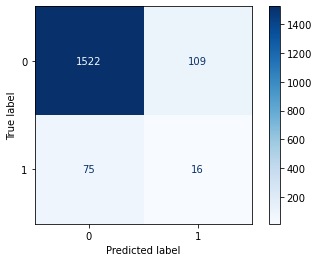

In [21]:
dict_lr = evaluation(model_lr, 'LogReg')

<div id="knn"></div>

### **KNeighborsClassifier (KNN)**

In [22]:
# Set up Pipeline for KNeighborsClassifier (KNN)
pipe_knn = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('knn', KNeighborsClassifier())
])

# Set up parameters for pipeline
pipe_knn_params = {
    'knn__p': [1, 2], # Test euclidean distance vs manhattan distance between datapoints
    'knn__weights': ['uniform', 'distance'], # Assign equal weightage to all datapoints vs "nearer"
    # neighbours having greater influence
    'knn__n_neighbors': range(1, 91, 10) # Vary number of neighbours above, below and at default (=5), 
    # limited to odd numbers
}

# Run gridsearch
model_knn = model_gridsearch(pipe_knn, pipe_knn_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Time taken: 130.53 seconds

Best Parameters:  {'knn__n_neighbors': 71, 'knn__p': 1, 'knn__weights': 'uniform'}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,KNN,0.8013,0.8713,0.8256,0.6574,0.8901,0.7672,0.2154


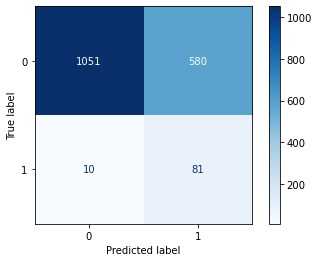

In [23]:
dict_knn = evaluation(model_knn, 'KNN')

<div id="randomforest"></div>

### **Random Forest**

In [24]:
# Set up Pipeline for Random Forest
pipe_rf = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('rf', RandomForestClassifier(random_state=42))
])

# Set up parameters for pipeline
pipe_rf_params = {   
    'rf__n_estimators': [50, 100, 200], # Vary number of trees in forest 
    'rf__max_depth': [2, 5, 10], # Maximum depth of the tree
    'rf__min_samples_leaf': [2, 5, 10], # Minimum number of samples required to be at a leaf node
    'rf__class_weight' : ['balanced', 'balanced_subsample'], # Weights associated with classes
    'rf__max_features': [None, 'auto'], # Set max features
}

# Run gridsearch
model_rf = model_gridsearch(pipe_rf, pipe_rf_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Time taken: 158.63 seconds

Best Parameters:  {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,RandomForest,0.813,0.8752,0.8709,0.7677,0.8352,0.7996,0.2754


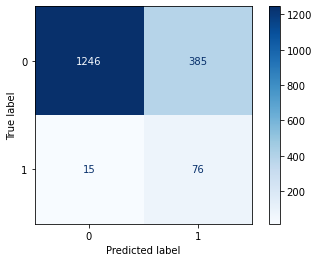

In [25]:
dict_rf = evaluation(model_rf, 'RandomForest')

<div id="extratrees"></div>

### **Extra Trees**

In [26]:
# Set up Pipeline for Extra Trees
pipe_et = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('et', ExtraTreesClassifier(random_state=42))
])

# Set up parameters for pipeline
pipe_et_params = {   
        'et__n_estimators': [50, 100, 200], # Vary number of trees in forest 
        'et__max_depth': [5, 10, 20, 50],  # Maximum depth of the tree
        'et__min_samples_leaf': [2, 5, 10, 20], # Minimum number of samples required to be at a leaf node
        'et__class_weight' : ['balanced', 'balanced_subsample']  # Weights associated with classes  
}

# Run gridsearch
model_et = model_gridsearch(pipe_et, pipe_et_params)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Time taken: 71.26 seconds

Best Parameters:  {'et__class_weight': 'balanced', 'et__max_depth': 50, 'et__min_samples_leaf': 5, 'et__n_estimators': 200}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,ExtraTrees,0.7917,0.9016,0.8544,0.8264,0.7143,0.7735,0.303


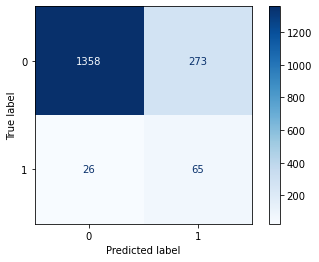

In [27]:
dict_et = evaluation(model_et, 'ExtraTrees')

<div id="adaboost"></div>

### **AdaBoost**

In [28]:
# Set up Pipeline for AdaBoost
pipe_ab = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('ab', AdaBoostClassifier(random_state = 42))
])

# Set up parameters for pipeline
pipe_ab_params = {   
    'ab__n_estimators': [25, 50, 100], 
    'ab__learning_rate': [0.1, 0.5, 1.0], 
}

# Run gridsearch
model_ab = model_gridsearch(pipe_ab, pipe_ab_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Time taken: 11.99 seconds

Best Parameters:  {'ab__learning_rate': 0.1, 'ab__n_estimators': 50}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,AdaBoost,0.8031,0.8131,0.8563,0.6754,0.8681,0.7664,0.2204


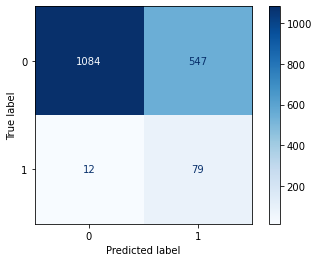

In [29]:
dict_ab = evaluation(model_ab, 'AdaBoost')

<div id="gradientboost"></div>

### **Gradient Boost**

In [30]:
# Set up Pipeline for Gradient Boost
pipe_gb = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('gb', GradientBoostingClassifier(random_state = 42))
])

# Set up parameters for pipeline
pipe_gb_params = {   
    'gb__n_estimators': [20, 50, 100, 200], 
    'gb__learning_rate': [0.01, 0.1, 0.5, 1.0], 
    'gb__max_depth': [2, 3, 5]
}

# Run gridsearch
model_gb = model_gridsearch(pipe_gb, pipe_gb_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Time taken: 81.33 seconds

Best Parameters:  {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 50}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,GradientBoost,0.8056,0.8378,0.8642,0.7195,0.8352,0.7741,0.2394


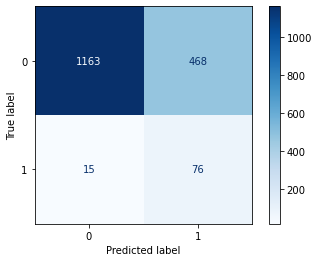

In [31]:
dict_gb = evaluation(model_gb, 'GradientBoost')

<div id="xgboost"></div>

### **XGBoost** 

In [32]:
# Set up Pipeline for XGBoost
pipe_xgb = Pipeline([
    ('smote', SMOTE(random_state = 42)), 
    ('xgb', XGBClassifier(random_state = 42))
])

# Set up parameters for pipeline
pipe_xgb_params = {   
    'xgb__n_estimators': [50, 100, 200], 
    'xgb__learning_rate': [0.05, 0.1, 0.2], 
    'xgb__max_depth': [2, 4, 6],
    'xgb__subsample': [0.5, 1.0], 
    'xgb__gamma': [0, 1, 5]
}

# Run gridsearch
model_xgb = model_gridsearch(pipe_xgb, pipe_xgb_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[01:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken: 489.00 seconds

Best Parameters:  {'xgb__gamma': 5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 50, 'xgb__subsample': 0.5}


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,XGBoost,0.8106,0.8702,0.8671,0.7828,0.7912,0.7868,0.278


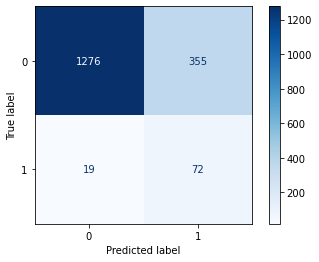

In [33]:
dict_xgb = evaluation(model_xgb, 'XGBoost')

<div id="modelevaluation"></div>

## **Model Evaluation**

<div id="scoringmetrics"></div>

### **Scoring Metrics** 

In [34]:
# Create dataFrame containing evaluation metrics of models
print(f"Evaluation Metrics of Various Model Types:")
display(pd.DataFrame([dict_lr, dict_knn, dict_rf, dict_et, dict_ab, dict_gb, dict_xgb]))

Evaluation Metrics of Various Model Types:


,model,GridSearch_score,train_score,validation_score,accuracy_valid,recall_valid,roc_auc_score,f1score_test
0,LogReg,0.7302,0.7823,0.7884,0.8931,0.1758,0.5545,0.1481
1,KNN,0.8013,0.8713,0.8256,0.6574,0.8901,0.7672,0.2154
2,RandomForest,0.8130,0.8752,0.8709,0.7677,0.8352,0.7996,0.2754
3,ExtraTrees,0.7917,0.9016,0.8544,0.8264,0.7143,0.7735,0.3030
4,AdaBoost,0.8031,0.8131,0.8563,0.6754,0.8681,0.7664,0.2204
5,GradientBoost,0.8056,0.8378,0.8642,0.7195,0.8352,0.7741,0.2394
6,XGBoost,0.8106,0.8702,0.8671,0.7828,0.7912,0.7868,0.2780


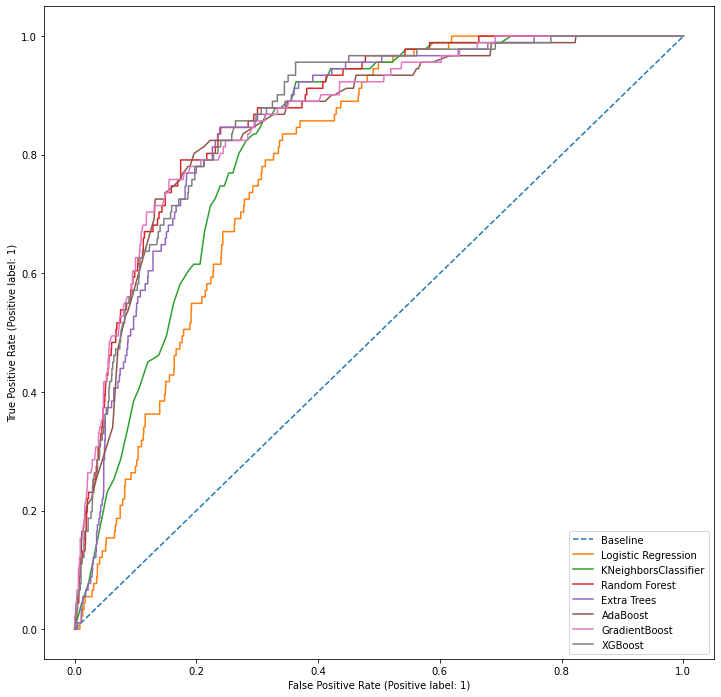

In [35]:
# Plot ROC Curve
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='Baseline', linestyle='--');
plot_roc_curve(model_lr, Xss_val, y_val,  label = 'Logistic Regression', ax = ax)
plot_roc_curve(model_knn, Xss_val, y_val, label = 'KNeighborsClassifier', ax = ax) 
plot_roc_curve(model_rf, Xss_val, y_val, label = 'Random Forest', ax = ax) 
plot_roc_curve(model_et, Xss_val, y_val, label = 'Extra Trees', ax = ax) 
plot_roc_curve(model_ab, Xss_val, y_val, label = 'AdaBoost', ax = ax) 
plot_roc_curve(model_gb, Xss_val, y_val, label = 'GradientBoost', ax = ax) 
plot_roc_curve(model_xgb, Xss_val, y_val, label = 'XGBoost', ax = ax) 
plt.show()

In order to choose the best model among the 7 models, our focus will be on ROC AUC score (which is the evaluation metric used by Kaggle to score the model), Accuracy (baseline to see how the model does) and Sensitivity or Recall Score (As False Negatives are dangerous in this case and aimed to be reduced).

Based on the evaluation metrics scores for 7 different models:
- The Random Forest model has the highest ROC AUC score (0.7996). It also has the highest grid search score (0.8130) and highest validation score (0.8709). This model has a high accuracy score on the validation set (0.7677) and a high recall score on the validation set (0.8352), despite these scores not being the best among other models. Of note, the model is only slightly overfitted.
- We will select the random forest given that it has the highest ROC AUC score.

### Pre-processing for Kaggle Submission

In [36]:
# Train dataset with dummy variables
X.head()

,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T090A,trap_T090B,trap_T090C,trap_T128A,trap_T200A,trap_T200B,trap_T218A,trap_T218B,trap_T218C,trap_T234
0,41.731922,-87.677512,29,5,2007,67.7,49.4,0.056,30.102,9.23,...,0,0,0,0,0,0,0,0,0,0
1,41.867108,-87.654224,29,5,2007,67.7,49.4,0.056,30.102,9.23,...,0,0,0,0,0,0,0,0,0,0
2,41.919343,-87.694259,29,5,2007,67.7,49.4,0.056,30.102,9.23,...,0,0,0,0,0,0,0,0,0,0
3,41.921965,-87.632085,29,5,2007,67.7,49.4,0.056,30.102,9.23,...,0,0,0,0,0,0,0,0,0,0
4,41.688324,-87.676709,29,5,2007,67.7,49.4,0.056,30.102,9.23,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Test dataset with dummy variables
X_test.head()

,latitude,longitude,dayofmonth,month,year,tavg,dewpoint,preciptotal,sealevel,avgspeed,...,trap_T231,trap_T232,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,41.95469,-87.800991,11,6,2008,71.6,61.7,0.265,29.803,10.74,...,0,0,0,0,0,0,0,0,0,0
1,41.95469,-87.800991,11,6,2008,71.6,61.7,0.265,29.803,10.74,...,0,0,0,0,0,0,0,0,0,0
2,41.95469,-87.800991,11,6,2008,71.6,61.7,0.265,29.803,10.74,...,0,0,0,0,0,0,0,0,0,0
3,41.95469,-87.800991,11,6,2008,71.6,61.7,0.265,29.803,10.74,...,0,0,0,0,0,0,0,0,0,0
4,41.95469,-87.800991,11,6,2008,71.6,61.7,0.265,29.803,10.74,...,0,0,0,0,0,0,0,0,0,0


In [38]:
## Standardise the full training set's discrete and continuous columns
# Create copy which will eventually have its discrete and continuous columns
Xss = X.copy()
yss = y.copy()
Xss_test = X_test.copy()

# Standardize the two X variables
ss1 = StandardScaler()
Xss[numcol] = ss1.fit_transform(X[numcol])
Xss_test[numcol] = ss1.transform(X_test[numcol])

In [39]:
# Ensuring that the columns for the test dataset and the train dataset are in the same order
Xss_test = Xss_test[Xss.columns]

In [40]:
# SMOTE used for the train dataset
sm = SMOTE(random_state = 42)
Xsm_train, ysm_train = sm.fit_resample(Xss, yss)

In [41]:
def kaggle_predict(model):
    # Fit model based on the full training set after scaling
    model.fit(Xsm_train, ysm_train)
    # Calculate train score
    trainscore = round(model.score(Xsm_train, ysm_train), 4)
    print(f"Train score: {trainscore}")
    # Get predictions of model on test set
    pred = model.predict(Xss_test)
    # Create a dataframe consisting of Id and model predictions on test set 
    predictions_col = pd.DataFrame({'WnvPresent': pred})
    id_col = pd.DataFrame({'Id': test['id']})
    pred_df = pd.concat([id_col, predictions_col], join = 'outer', axis = 1)
    return pred_df

### Final Models for Kaggle

In [42]:
# Dummy Classifier
dc = DummyClassifier(strategy="constant", constant = 1)
kaggle_dc = kaggle_predict(dc)

Train score: 0.5


In [43]:
# Logistic Regression using the best parameters 
lr_final = LogisticRegression(solver = 'saga', random_state = 42, C = 1.0, penalty = 'l2')
kaggle_lr = kaggle_predict(lr_final)

Train score: 0.9303


In [44]:
# KNN using the best parameters 
knn_final = KNeighborsClassifier(n_neighbors = 71, p = 1, weights = 'uniform')
kaggle_knn = kaggle_predict(knn_final)

Train score: 0.8112


In [45]:
# Random Forest using the best parameters 
rf_final = RandomForestClassifier(random_state=42, class_weight = 'balanced', max_depth = 10, 
                                  max_features = 'auto', min_samples_leaf = 5, n_estimators = 200)
kaggle_rf = kaggle_predict(rf_final)

Train score: 0.8543


In [46]:
# Extra Trees using the best parameters 
et_final = ExtraTreesClassifier(random_state=42, class_weight = 'balanced', max_depth = 50,
                                min_samples_leaf = 5, n_estimators = 200)
kaggle_et = kaggle_predict(et_final)

Train score: 0.8934


In [47]:
# AdaBoost using the best parameters 
ab_final = AdaBoostClassifier(random_state = 42, learning_rate = 0.1, 
                              n_estimators = 100)
kaggle_ab = kaggle_predict(ab_final)

Train score: 0.7866


In [48]:
# Gradient Boosting using the best parameters 
gb_final = GradientBoostingClassifier(random_state = 42, learning_rate = 0.1, 
                                      max_depth = 2, n_estimators = 50)
kaggle_gb = kaggle_predict(gb_final)

Train score: 0.8125


In [49]:
# XGBoost using the best parameters 
xgb_final = XGBClassifier(random_state = 42, colsample_bytree = 1.0, gamma = 5, 
                          learning_rate = 0.1, max_depth = 5, n_estimators = 100, subsample = 0.5)
kaggle_xgb = kaggle_predict(xgb_final)

[01:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score: 0.9003


In [50]:
# Exporting the kaggle submission to file
kaggle_dc.to_csv('kaggle/kaggle_submission_dc.csv', index=False)
kaggle_lr.to_csv('kaggle/kaggle_submission_lr.csv', index=False)
kaggle_knn.to_csv('kaggle/kaggle_submission_knn.csv', index=False)
kaggle_rf.to_csv('kaggle/kaggle_submission_rf.csv', index=False)
kaggle_et.to_csv('kaggle/kaggle_submission_et.csv', index=False)
kaggle_ab.to_csv('kaggle/kaggle_submission_ab.csv', index=False)
kaggle_gb.to_csv('kaggle/kaggle_submission_gb.csv', index=False)
kaggle_xgb.to_csv('kaggle/kaggle_submission_xgb.csv', index=False)

In [51]:
kaggle_rf.to_csv('kaggle/kaggle_submission_rf.csv', index=False)

### Kaggle Scores

| model | train_score | kaggle_score |
|---|---|---|
|**Dummy Classifier**|0.5|0.50000|
|**Logistic Regression**|0.9303|0.53764|
|**KNeighborsClassifier**|0.8112|0.59332|
|**Random Forest**|0.8534|0.60304|
|**Extra Trees**|0.8934|0.56913|
|**AdaBoost**|0.7866|0.62656|
|**Gradient Boost**|0.8125|0.65179|
|**XGBoost**|0.9003|0.60325|

<div id="featureimportances"></div>

### **Feature Importances** 

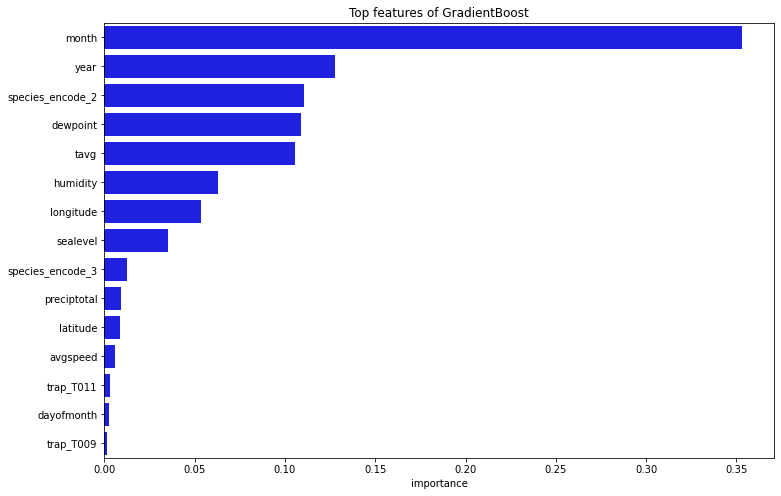

In [52]:
# Feature importances for gradient boost
importance = pd.DataFrame(gb_final.feature_importances_,
                          index=Xsm_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'importance'})

# plot the top 20 important features
plt.figure(figsize=(12, 8))
plt.title(f"Top features of GradientBoost", fontsize = 12)
sns.barplot(data=importance.head(20), x='importance', y=importance.index[:20], color = 'blue');

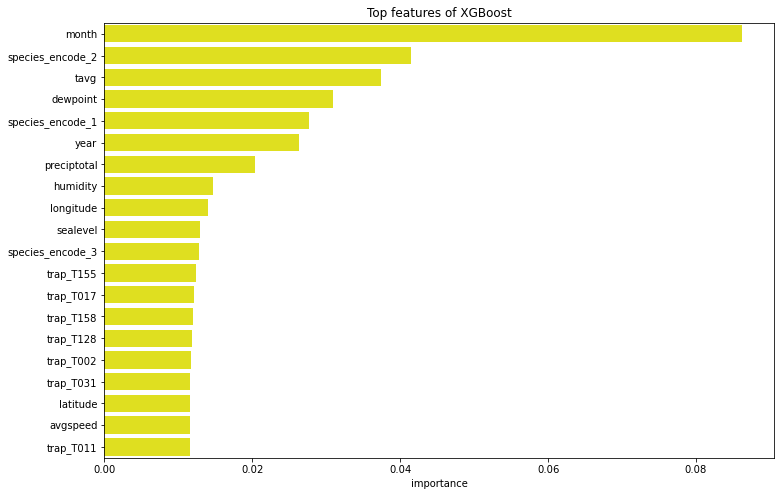

In [53]:
# Feature importances for xgboost
importance = pd.DataFrame(xgb_final.feature_importances_,
                          index=Xsm_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'importance'})

# plot the top 20 important features
plt.figure(figsize=(12, 8))
plt.title("Top features of XGBoost", fontsize = 12)
sns.barplot(data=importance.head(20), x='importance', y=importance.index[:20], color = 'yellow');

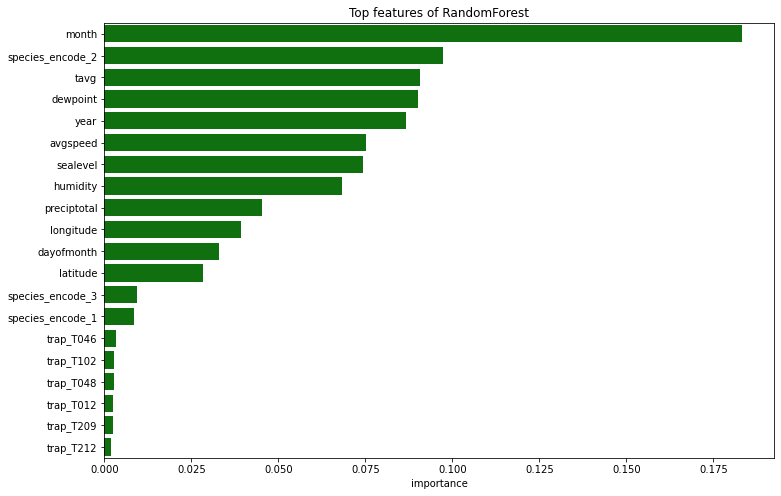

In [54]:
# Feature importances for RandomForest
importance = pd.DataFrame(rf_final.feature_importances_,
                          index=Xsm_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'importance'})

# plot the top 20 important features
plt.figure(figsize=(12, 8))
plt.title("Top features of RandomForest", fontsize = 12)
sns.barplot(data=importance.head(20), x='importance', y=importance.index[:20], color = 'green');

<div id="cba"></div>

## **Cost-Benefit Analysis**

*'Spraying is a safe and effective way to control disease carrying mosquitoes. By reducing the number of mosquitoes in high-risk areas we expect that this will help minimize the number of human cases of West Nile Virus in Chicago.'*  
*-Cort Lohff (CDPH Environmental Health Medical Director, 2013)* ([*source*](https://abc7chicago.com/archive/9206273/))

In 2013, the Chicago Department of Public Health's (CDPH) Environmental Health Medical Director boldly claimed that spraying was an effective means of eradicating mosquito count and by extension, the number of WNV cases in Chicago. Yet, as recently as 2022, there were 42 infected human cases and 4 deaths reported in Illinois ([*source*](https://abc7chicago.com/west-nile-virus-symptoms-of-2021-what-is/10929775/)). Hence, this begs the question of the effectiveness of spraying as a measure against WNV. To begin the cost-benefit analysis (CBA), we must first understand that there are two types of spraying agents (larvicides and adulticides) and two methods of spray dispersion (aerial and truck) ([*source*](https://www.cdc.gov/mosquitoes/mosquito-control/community/mosquito-control-during-outbreak.html)). From the [*kaggle competition page*](https://www.kaggle.com/c/predict-west-nile-virus/overview), it is stated that the "the city will spray airborne pesticides to control adult mosquito populations", which may be construed as the the spraying agent being a form of adulticide. This is corroborated by the earlier referenced article, which states that the material used (Zenivex™) is intended to control adult mosquitoes. Specifically, it is mentioned that "spraying will begin at dusk (...) continue through the night until approximately 1:00am, with mosquito abatement technicians in trucks dispensing an ultra-low-volume spray". To add, "spraying is done after sunset until midnight (...) During this timeframe the mosquito is actively seeking a blood meal, and spraying at this time allows us to control the adult mosquito with a minimal risk of exposure to the public or beneficial insects" ([*source*](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox)). 

<img src = "images/wnv_trend.png" alt = "wnv_trend"/>

*Fig. 4 Reported West Nile Virus Cases by US State (1999-2020)* ([*source*](https://www.cdc.gov/westnile/statsmaps/cumMapsData.html))


<div id="cost"></div>

### **Cost**
 - The selling price of the spraying agent (Zenivex E4) is USD58 for 16oz (USD450/gallon) ([*source*](https://www.solutionsstores.com/etofenprox-rtu)) and consumed at a rate of 1.5 fluid ounces per acre ([*source*](https://abc7chicago.com/archive/9206273/)) (0.0117gallon/acre or 2.891gallon/km^2). With reference to Fig. 4 below, an approximate 70% of Chicago's land area (~606km^2) has observed WNV occurence in the train dataset study period, which equates to ~424km^2. By estimation, for every Zenivex E4 spraying cycle, the monetary cost involved is USD450 x 2.891gallon/km^2 x 424km^2 = ~USD550,000. From the spray dataset, spraying was conducted on two dates (29 Aug, 7 Sep) in 2011 and eight dates (17 Jul, 25 Jul, 8 Aug, 15 Aug, 16 Aug, 22 Aug, 29 Aug, 5 Sep) in 2013 respectively, from anything between 2 to 5 hours. Assuming there are no changes in trend to adopt a more conservative position, there will be a total of 8 sprays annually divided up on a weekly basis during the heightened WNV period. Thus, the annual monetary cost of spraying to control WNV spread is USD550,000 x 8 cycles = USD4.4 million.  
 
 - From an [*article*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4340646/) titled "Comparison of the Efficiency and Cost of West Nile Virus Surveillance Methods in California", surveillance cost associated with setting up, monitoring and maintaining mosquitoe traps is USD72 per week. Based on the ~135 number of traps in Chicago, the total annual surveillance cost (assuming only summer months from May to Oct as per the train/test datasets) amounts to 136 x 72 x 6 x 4 = ~USD235,000. 
 
 - Operational cost including manpower/labour cost, truck fuel etc. Due to the varied nature of this cost, we are unable to estimate the monetary value.  

 - Negative externalities generated to surroundings as a result of spraying, including medical cost associated with asthma symptoms, temporary ceasure of businesses/activities, irritation from prolonged exposure etc. Due to the immaterial nature of disamenities, we are unable to estimate the monetary value. 


<div id="benefit"></div>

### **Benefit**
 - The most straightforward benefit of spraying is the savings from otherwise incurred medical fee. In a related [*study*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) to the article above, medical treatment for WNV can be broadly classified as either West Nile fever (WNF - mild bodily response with similar symptoms to flu) or West Nile Neuroinvasive Disease (WNND - typically in the form of meningitis/encephalitis in which the patient experiences severe symptoms). Treatment cost is about USD300 for the former and USD33,000 for the latter. Over the past 20 years, there have been about 2,700 WNV cases in Illinois, which amounts to 135 positive cases annually on average. From CDC's website, only 20% of individuals experience WNF while a much lesser 0.667% of individuals experience WNND. In the context of Chicago, these percentages translate to 27 individuals with WNF and 1 person with WNND. The total annual medical treatment cost in Chicago is 27(300) + 1(33000) = USD41,110. 
 - Apart from medical fees, an opportunity cost in the form of loss of economic productivity is incurred. Based on the [*US Census Bureau*](https://www.census.gov/quickfacts/fact/table/chicagocityillinois/LND110210), the latest median household income for Chicago is USD58,247. Assuming WNF/WND takes half/full month respectively to recover, the larger annual economic loss arising from WNV is 27(58247/24) + 1(58247/12) = USD70,382. 
 - Lastly, there will be an element of reduced pain/suffering engendered by WNV symptoms, which is difficult to quantify, not to mention additional burden and pressure placed on caregivers as well.  


Analyzing both costs and benefits collectively, the **annual net cost/benefit = (USD41,110 + USD70,382) - (USD4,400,000 + USD235,000) = -USD4,523,518**. While only a handful of factors were considered and multiple underlying assumptions were made for the sake of calculation, the results nonetheless show that the costs of spraying heavily outweigh the benefits. Hence, adopting a blanket approach in spraying all predicted WNV areas is not advisable. This is in part attributed to the weaker-than-desired production model perforamnce. Rather, the following recommendations are put forth: 


In [55]:
combined_train_df = pd.read_csv('datasets/train_featureeng.csv')

combined_train_df.columns = combined_train_df.columns.str.strip()
combined_train_df.columns = combined_train_df.columns.str.replace(' ', '_')
combined_train_df.columns = combined_train_df.columns.str.lower()

In [56]:
chicago_folium_map = folium.Map(location = [41.878876, -87.635918], 
                        height = 800, 
                        width = 1200, 
                        zoom_start = 12, 
                        control_scale = True)


In [57]:
mos_latlong_df = pd.DataFrame({'nummosquitos': combined_train_df.nummosquitos, 
                              'lat': combined_train_df.latitude,
                              'long': combined_train_df.longitude})

mos_lat = mos_latlong_df.lat.tolist()
mos_long = mos_latlong_df.long.tolist()


In [58]:
HeatMap(list(zip(mos_lat, mos_long)), radius = 16, gradient = {0.1: ' ivory', 0.5: 'orange',
                                                               1.0: 'red'}).add_to(chicago_folium_map)


In [59]:
spray_clean_df = pd.read_csv('datasets/spray_featureeng.csv')

spray_clean_df.columns = spray_clean_df.columns.str.strip()
spray_clean_df.columns = spray_clean_df.columns.str.replace(' ', '_')
spray_clean_df.columns = spray_clean_df.columns.str.lower()

spray_clean_df['date'] = pd.to_datetime(spray_clean_df['date'])

spray_clean_df['day'] = (spray_clean_df['date'].dt.strftime('%d')).astype(int)
spray_clean_df['month'] = (spray_clean_df['date'].dt.strftime('%m')).astype(int)
spray_clean_df['year'] = (spray_clean_df['date'].dt.strftime('%y')).astype(int)

In [60]:
spray_clean_df = spray_clean_df.drop(spray_clean_df[(spray_clean_df['latitude'] > 42) & 
                                                    (spray_clean_df['longitude'] < -88)].index)

spray_lat = spray_clean_df.latitude.tolist()
spray_long = spray_clean_df.longitude.tolist()

In [61]:
HeatMap(list(zip(spray_lat, spray_long)), blur = 50, radius = 16, 
        gradient = {0.1: ' yellow', 0.5:'lime', 1.0: 'green'}).add_to(chicago_folium_map)

In [62]:
display(chicago_folium_map)

To view the output map, open and/or run this notebook in Jupyter Notebook.

<div id="recommendations"></div>

### **Recommendations**
a) Instead of spraying all predicted WNV areas, a more targetted approach may be taken by only spraying areas with repeated WNV incidences over the years. With reference to the folium heatmap above, these locations include:  
- Norridge/Elmwood Park - Suburb-styled residential areas in the northern part of Chicago  
- Lower West Side/McKinley Park - Southern periphery of the main CBD area with some apartment-styled buildings  
- Calumet Heights/Riverdale/Beverly - Mainly suburb-styled residential areas near industrial developments in southern part of Chicago  

b) Building on the preceding point, more context-specific studies may be carried out on areas with persistent WNV occurences. Possible relationships may be established between certain types of land uses and WNV rates. Using Norridge/Elmwood Park as an example, the presence of an adjacent nature reserve (Schiller Woods) may prove conducive breeding grounds for mosquitoes and hence, result in more WNV cases observed in surrounding neighbourhoods. Similarly for Riverdale, the neighbourhood might experience higher WNV rates as it is in close proximity to the Calumet Water Reclamation Plant, where conditions are favourable for moquitoe breeding.  

c) Additionally, the DATA-SCIENCE research team should identify more predictor variables to ensure robustness and comprehensiveness of the production model. At present, only climatic variables (e.g. temperature, precipitation, humidity, wind speed) are considered in the model. In reality, there are other contributing factors, which encompasses but is not limited to the built environment, biodiversity ecosystems and human behaviour.   

d) Lastly, part of the funds may be allocated to educating the masses as human actions have a direct impact on the mosquitoe growth rate. 

<div id="conclusion"></div>

## **Conclusion**

Wrapping up, we return to the objective set in the introductory chapter: develop a classification-based prediction model to identify the spatiality and temporality (i.e. when and where) of WNV in Chicago. To ensure a minimal level of model performance, a benchmark of 80% for all scoring metrics was established. Through running multiple models (LogReg, KNN, Random Forest, Extra Trees, AdaBoost, Gradient Boost, XGBoost) and rounds of tuning, the final selected production model has the following parameters: 
- *Model type: Random Forest*
- Class Weight: Balanced Sample  
- Max Depth: 10
- Max Features: Auto
- Min Samples Leaf: 5
- N Estimators: 200

||Predicted WNV Absent|Predicted WNV Prsent|
|---|---|---|
|Actual WNV Absent|1246|385|
|Actual WNV Present|15|76|

When the production model is applied to the test dataset, the true positives/negatives vis-a-vis the false positives/negatives are as shown in the confusion matrix above. The skewed proportion of true positives/negatives roughly corresponds with the imbalanced dataset, where the ratio of positives (WNV present) to negatives (WNV absent) is about 5:95. As shown by the relatively high false positive value of 385, the model's main flaw is in overpredicting locations with WNV presence when in fact, the observation should be a negative. The material implication is a wastage of resources in spraying/treating areas identified as WNV risk when it is not the case in reality.   


<img src = "images/rf_fi.png" alt = "randomforest_featureimportance"/>

*Fig. 5 Feature Importance for Random Forest Model*

While the feature importance value is not directly interpretable for a Random Forest model, it still serves as a proxy highlighting more pertinent predictors, with Month ranked as the most important feature by far followed by climatic variables. This is because the climatic factors vary seasonally, with their collective effects largely reflected according to the month of the year (i.e. temperature, precipitation, humidity etc. is depedent on time). Year ranks highly as well, and this is due to a high incidence of WNV cases being concentrated in 2007 and 2013. Also, six traps (T048, T102, T209, T046, T073, T200) were surfaced as well, which based on their coordinates, tally with the locations identified with higher WNV risk (e.g. Lower West Side, Calumet Heights, Riverdale) under the 'Recommendations' subsection. 


|Model|Accuracy|ROC-AUC|Sensitivity|F1-score|
|---|---|---|---|---|
|Random Forest|0.7677|0.7996|0.8352|0.2754|

Regrettably, with the exception of sensitivity, the production model falls slightly short of the established scoring benchmark of 80%, largely due to the narrow scope of predictor variables (primarily climatic variables) made available for assessment. Particularly alarming is the low F1-score of 0.2754, which is attributed to the low precision arising from the model's inclination towards false positives. Recommendations on additional predictors for consideration are covered in the previous section. Nonetheless, the production model value adds by partially addressing the goal set in the problem statement, which is to predict when and where WNV will occur in Chicago. To this end, based on the study findings, WNV will likely escalate during summer months where temperature, precipitation and relative humidity are higher, in the i) northern residential neighbourhoods, ii) southern periphery of the CBD area, and iii) residential areas near industrial sites in the southern region of Chicago. 
